<img src="./pics/fcdn_logo_large.png" style="float: right"/>

<br>
<br>
<br>

# Objetivo de la Notebook
* Instalar las librerías necesarias.
* Cargar los datos de entrenamiento (Debido a que trabajamos con datos confidenciales, usaremos datos desde [Kaggle](https://www.kaggle.com/datasets/arseniitretiakov/noticias-falsas-en-espaol?select=onlyfakes1000.csv)
* Generar un EDA
* Entrenamiento
* Testing del Modelo

# Instalar las librerías necesarias
En caso de utilizar [Google Colab](https://colab.research.google.com/).

In [1]:
#!pip install transformers==4.2.2
#!pip install datasets

In [2]:
!nvidia-smi

Wed Oct 19 15:37:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P5    36W / 250W |    604MiB /  7982MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importamos las librerías necesarias

In [3]:
import torch, os, re, pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding, GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, AutoConfig
from datasets import Dataset
import unicodedata

In [9]:
torch.__version__

'1.9.0'

# Cargamos los datos

<img src="./pics/kagle_noticias_falsas_en_español.png"/>

In [7]:
df = pd.read_csv('./dataset/onlyfakes1000.csv')

In [8]:
df

,text
0,El suceso ha tenido lugar en Brasil. Un adole...
1,Estamos en la semana decisiva. Los expertos a...
2,Estudios científicos hay muchos. Unos nos int...
3,Ha sucedido en la ciudad de San José de Río P...
4,La fiesta en Sevilla por el vuelco electoral ...
...,...
995,Reenviado... Me acaban de llegar a casa por co...
996,"JULIO ANGUITA: ""El que debería estar en la cár..."
997,Otegi reclama la salida de prisión de todos lo...
998,Otegi reclama la salida de prisión de todos lo...


In [53]:
df['text'][0]

' El suceso ha tenido lugar en Brasil. Un adolescente de 16 años murió después de masturbarse 42 veces seguidas. Sin parar. Según el informe de las autoridades el joven comenzó a medianoche y se pasó toda la noche y madrugada haciendo secuencias de mastur'

# EDA

In [19]:
df['len'] = df['text'].apply(lambda x : len(x))

In [29]:
df[df['len'] > 500]

,text,len
276,El gobierno ha aprobado un decreto ley en últi...,2052
760,"Según informa el digital El Cadenazo, la alcal...",1030


In [44]:
df = df.drop(df[df['len'] > 500].index)

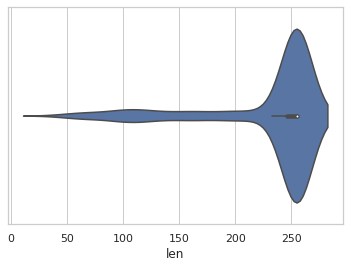

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x=df['len'])
plt.show()

# Cargo el Módelo de [Hugging Face](https://huggingface.co/)

In [50]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)
torch.cuda.empty_cache()
device 

device(type='cuda', index=0)

In [51]:
# Cargamos el modelo pre-entrenado
base_model = GPT2LMHeadModel.from_pretrained('datificate/gpt2-small-spanish')

Downloading:   0%|          | 0.00/817 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [52]:
# Cargamos el tokenizador
base_tokenizer = GPT2Tokenizer.from_pretrained('datificate/gpt2-small-spanish', use_fast=True) #, truncation=True, max_length = 512, padding=True

Downloading:   0%|          | 0.00/850k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/387 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

In [62]:
text = "El suceso ha tenido lugar en Brasil"
text_ids = base_tokenizer.encode(text, return_tensors = 'pt')

generated_text_samples = base_model.generate(
    text_ids
)
for i, beam in enumerate(generated_text_samples):
    print(f"{i}: {base_tokenizer.decode(beam, skip_special_tokens=True)}")
    print()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: El suceso ha tenido lugar en Brasil, donde el gobierno brasileño ha prohibido la venta de alcohol en el



In [65]:
def dataset_train(df, feature):    
    df['text'] = base_tokenizer.bos_token + ' ' + df[feature] + ' ' + base_tokenizer.eos_token
    #Separo datos para entrenamiento y validación
    train, val = train_test_split(df['text'], train_size = 0.9, random_state = 77)
    print(f'Hay {len(train)} textos para entrenamiento y {len(val)} para validación')
    
    df_train = pd.DataFrame(train)
    df_val = pd.DataFrame(val)
    # Cargamos los datos desde pandas df
    train_dataset = Dataset.from_pandas(df_train[['text']])
    val_dataset = Dataset.from_pandas(df_val[['text']])

    def tokenize_function(examples):
        return base_tokenizer(examples['text'])


    tokenized_train_dataset = train_dataset.map(
        tokenize_function,
        batched=True,
        num_proc=5,
        remove_columns=['text'],
    )
    tokenized_val_dataset = val_dataset.map(
        tokenize_function,
        batched=True,
        num_proc=5,
        remove_columns=['text'],
    )

    model_path = './model_fake_news'

    training_args = TrainingArguments(
        output_dir=model_path,          # Directorio donde se va a guardar el modelo
        num_train_epochs=6,              # cantidad de epochs
        per_device_train_batch_size=2,  # batch size durante el entrenamiento
        per_device_eval_batch_size=8,   # batch size durante la evaluación
        warmup_steps=200,                # número de pasos para el learning rate "De menor a mayor"
        weight_decay=0.01,               # penalización para los pesos (weight)
        logging_dir=model_path,            # directorio para logs
        prediction_loss_only=True,
        save_steps=10000 
    )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=base_tokenizer,
        mlm=False
    )

    trainer = Trainer(
        model=base_model,                         # Modelo base
        args=training_args,                       # argumentos de entrenamiento
        data_collator=data_collator,
        train_dataset=tokenized_train_dataset,    # dataset de entrenamiento
        eval_dataset=tokenized_val_dataset        # dataset para evaluar
    )
    trainer.train()
    trainer.save_model()
    base_tokenizer.save_pretrained(model_path)

In [66]:
for feature in ['text']: #En caso que tuvieran otras columnas para entrenar.
    print(f'Entreno modelo =========> {feature}')
    dataset_train(df, feature)

Entreno modelo =========> text
Hay 898 textos para entrenamiento y 100 para validación


The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__.
***** Running training *****
  Num examples = 898
  Num Epochs = 6
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 2694


  0%|          | 0/2694 [00:00<?, ?it/s]

{'loss': 4.6339, 'learning_rate': 4.398556535685646e-05, 'epoch': 1.11}
{'loss': 3.7347, 'learning_rate': 3.396150761828388e-05, 'epoch': 2.23}
{'loss': 3.1623, 'learning_rate': 2.393744987971131e-05, 'epoch': 3.34}
{'loss': 2.7449, 'learning_rate': 1.3913392141138735e-05, 'epoch': 4.45}
{'loss': 2.5068, 'learning_rate': 3.889334402566159e-06, 'epoch': 5.57}




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./model_fake_news
Configuration saved in ./model_fake_news/config.json


{'train_runtime': 169.12, 'train_samples_per_second': 31.859, 'train_steps_per_second': 15.93, 'train_loss': 3.287077622672055, 'epoch': 6.0}


Model weights saved in ./model_fake_news/pytorch_model.bin
tokenizer config file saved in ./model_fake_news/tokenizer_config.json
Special tokens file saved in ./model_fake_news/special_tokens_map.json


In [77]:
def generate_n_text_samples(model, tokenizer, input_text, device, n_samples = 5, max_length=100):
    text_ids = tokenizer.encode(input_text, return_tensors = 'pt')
    text_ids = text_ids.to(device)
    model = model.to(device)

    generated_text_samples = model.generate(
        text_ids, 
        max_length= max_length,  
        num_return_sequences= n_samples,
        no_repeat_ngram_size= 2,
        repetition_penalty= 1.5,
        top_p= 0.92,
        temperature= .85,
        do_sample= True,
        top_k= 125,
        early_stopping= True
    )
    gen_text = []
    for t in generated_text_samples:
        text = tokenizer.decode(t, skip_special_tokens=True)
        gen_text.append(text)

        return gen_text

In [80]:
# trained model loading
feature = 'text'
model_path = './model_fake_news'


fake_news_model = GPT2LMHeadModel.from_pretrained(model_path)
fake_news_tokenizer = GPT2Tokenizer.from_pretrained(model_path)

device = "cuda:0"

loading configuration file ./model_fake_news/config.json
Model config GPT2Config {
  "_name_or_path": "datificate/gpt2-small-spanish",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.9.2",
  "use_cache": true,
  "vocab_size": 50257
}

loading weights file ./model_fak

In [81]:
#input_text = fake_news_tokenizer.bos_token
input_text = 'La Guardia Civil'

fake_news = generate_n_text_samples(fake_news_model, fake_news_tokenizer, 
                                    input_text, device, n_samples = 5, max_length=100)
for h in fake_news:
    print(h)
    print()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


La Guardia Civil y Policía Nacional, civiles de España; han sido detenidos los dos periodistas españoles que se publicaban en un programa nocturno La Tribuna. Uno ha recibido la Legión de Honor del Parlamento Europeo por su labor protag усторава́ en favor d того сомотат  ра онод а Ño ́раÑa txu mateu lionar q lo he

